In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
"""
Rust Model construct, nothing need to change here
"""
import pandas as pd
import numpy as np
import random as rnd
import scipy.stats as stats
import scipy.optimize as opt
import json as json
import matplotlib as mpl
from math import exp
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.display import display
from IPython.core.display import HTML
rnd.seed(2)
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize


def lin_cost(s, params):
   try:
       theta1_1, = params
       return s*theta1_1/1000
   except ValueError:
       raise ValueError
       print("Wrong number of parameters specified: expected 2, got {}".format(len(params)))

class DynamicLogit(object):
    def __init__(self, data, Y, X, npars=2,dim_s =175,time=117,nbus=37,MF=lin_cost):
        """
        A statistics workbench used to evaluate the cost parameters underlying 
        a bus replacement pattern by a forward-looking agent.
        
        Takes:
            * Data: a Pandas dataframe, which contains:
                -Y: the name of the column containing the dummy exogenous 
                    variable (here, the choice)
                -X: the name of the column containing the endogenous variable 
                    (here, the state of the bus)

            * p: The state-transition vector of endogenous variable.
                    For instance, p = [0, 0.6, 0.4] means that the bus will 
                    transition to the next mileage state with probability 0.6, 
                    and to the second next mileage state with probability 0.4.

            * MF: A function passed as an argument, which is the functional 
                  form for the maintenance cost. This function must accept as
                  a first argument a state s, and as a second argument a vector
                  of parameters.
                  
            * npars: The number of parameters to evalutate (i.e. the number of 
                     parameters of the maintenance cost function, plus 1 for
                     the replacement cost)
        """   
        self.time = int(time)
        self.nbus = int(nbus)     
        
        self.endog = data.loc[:, Y].values #Choice/action
        self.exog = data.loc[:, X].values  #State
        
        self.N = self.endog.shape[0]
        self.S = int(dim_s)    
        
        # Check that the stated number of parameters correspond to the
        # specifications of the maintenance cost function.       
        try:
            MF(1, [0]*(npars-1))
        except ValueError:
            raise ValueError(("The number of parameters specified does not "
                              "match the specification of the maintenance cost"
                              " function!"))
        else:
            self.MF = MF
            self.npars = npars
        
        S = self.S

        # A second (SxS) matrix which regenerates the bus' state to 0 with
        # certainty (used to compute the replacement utility)
        self.regen_mat = np.vstack((np.ones((1, S)),np.zeros((S-1, S)))).T

    def transMat(self,theta2):    
        #theta2 =  self.fitted2.x
        S = self.S
        self.p = np.array([theta2[0],theta2[1],theta2[2],1-sum(theta2)])
        # A (SxS) matrix indicating the probability of a bus transitioning
        # from a state s to a state s' (used to compute maintenance utility)
        
        self.trans_mat = np.zeros((S, S))
        for i in range(S):
            for j, _p in enumerate(self.p):
                if i + j < S-1:
                    self.trans_mat[i][i+j] = _p
                elif i + j == S-1:
                    self.trans_mat[i][S-1] = self.p[j:].sum()
                else:
                    pass

    def belief(self,theta2,path,path_action):
        """
        This function return the belief x
        Takes:
            * theta2: the true state transition probability            
            * A path of mileage and replacement\maintenance record data
        """
        length = self.time

        x = 0

        p_0 = theta2[0]
        p_1 = theta2[1]
        p_2 = theta2[2]
        p_3 = 1-p_0-p_1-p_2
        #print(length,path)
        # count_0 = 0
        # count_1 = 0
        # count_2 = 0
        # count_3 = 0

        for i in range(length-1):
            if path_action[i] ==0:
                gap = path[i+1]-path[i]
                if gap == 0:
                    #count_0 +=1
                    x = x + np.log(p_0)
                elif gap == 1:
                    #count_1 +=1
                    x = x + np.log(p_1)
                elif gap == 2:
                    #count_2 +=1
                    x = x + np.log(p_2)
                else:
                    #count_3 +=1
                    x = x + np.log(p_3)
            else:
                gap = path[i+1]
                if gap == 0:
                    #count_0 +=1
                    x = x + np.log(p_0)
                elif gap == 1:
                    #count_1 +=1
                    x = x + np.log(p_1)
                elif gap == 2:
                    #count_2 +=1
                    x = x + np.log(p_2)
                else:
                    #count_3 +=1
                    x = x + np.log(p_3)
        return x#count_0*np.log(p_0)+count_1*np.log(p_1)+\
               #count_2*np.log(p_2)+count_3*np.log(p_3)  
    
    def myopic_costs(self, params): # - reward function
        S = self.S
        """
        This function computes the myopic expected cost associated with each 
        decision for each state.
        
        Takes:
            * A vector params, to be supplied to the maintenance cost function 
              MF. The first element of the vector is the replacement cost rc.

        Returns:
            * A (Sx2) array containing the maintenance and replacement costs 
              for the S possible states of the bus
        """
        rc = params[0]          #F : action 1
        thetas = params[1:]     #c : action 0
        maint_cost = [-self.MF(s, thetas) for s in range(0, S)]
        repl_cost = [-rc for s in range(0, S)]  #action 1
        return np.vstack((maint_cost, repl_cost)).T
    
    def fl_costs(self, params, beta=0.9999):#, threshold=1e-6, suppr_output=False): #compute V^n
        """
        Compute the non-myopic expected value of the agent for each possible 
        decision and each possible state of the bus, conditional on a vector of 
        parameters and on the maintenance cost function specified at the 
        initialization of the DynamicUtility model.

        Iterates until the difference in the previously obtained expected value 
        and the new expected value is smaller than a constant.
        
        Takes:
            * A vector params for the cost function
            * A discount factor beta (optional)
            * A convergence threshold (optional)
            * A boolean argument to suppress the output (optional)

        Returns:
            * An (Sx2) array of forward-looking costs associated with each
              state and each decision.
        """
        achieved = True
        # Initialization of the contraction mapping
        k = 0
        EV = np.ones((self.S, 1))        

        self.EV_myopic = self.myopic_costs(params)
        EV_new = np.zeros((self.S, 1))
       
        # Contraction mapping Loop
        for k in range(1000):
            EV = EV_new 
            #pchoice = self.choice_prob(EV) #\pi_theta(s,a)
            Q0 = self.EV_myopic[:,0] + beta * self.trans_mat.dot(EV).reshape(-1)
            Q1 = self.EV_myopic[:,1] + beta * EV[0]
            Q = np.vstack((Q0,Q1)).T
            
            min_cost = Q.max(1).reshape(-1,1)
            cost = Q - min_cost
            util = np.exp(cost)
            EV_new =  min_cost + np.log(util.sum(1).reshape(-1,1))
            
            k += 1

        return EV_new,Q

    def choice_prob(self, cost_array):  #\pi_theta(s,a)
        """
        Returns the probability of each choice for each observed state, 
        conditional on an array of state/decision costs (generated by the 
        myopic or forward-looking cost functions)
        """
        cost = cost_array - cost_array.max(1).reshape(-1,1)
        util = np.exp(cost)
        pchoice = util/(np.sum(util, 1).reshape(-1,1))
        return pchoice
        
    def loglike(self, params):
        """
        The log-likelihood of the Dynamic model is estimated in several steps.
        1°) The current parameters are supplied to the contraction mapping 
            function
        2°) The function returns a matrix of decision probabilities for each 
            state.
        3°) This matrix is used to compute the loglikelihood of the 
            observations
        4°) The log-likelihood are then summed accross individuals, and 
            returned
        """
        utilV,utilQ = self.fl_costs(params)#, suppr_output=True) 
        pchoice = self.choice_prob(utilQ)    

        logprob = 0
        for sample_data in range(self.N):
            action = int(self.endog[sample_data])
            state = int(self.exog[sample_data])
            logprob += np.log(pchoice[state,action]) 
        return -logprob   
        
    def fit_likelihood(self, x0=None, bounds=None):
        """
        Fit the parameters to the data.
        """
        if bounds == None:
            #bounds = [(10.5,None),(1e-6,None)]
            bounds = [(1e-6, None) for i in range(self.npars)]
            
        if x0 == None:
            x0 = [0.1 for i in range(self.npars)]
            
        self.fitted = minimize(self.loglike, x0=x0,bounds = bounds)
               
    def loglike2(self,theta2):
        
        self.beli = 0
        for i in range(self.nbus):
            self.beli = self.beli + self.belief(theta2,self.exog[i*self.time:(i+1)*self.time],self.endog[i*self.time:(i+1)*self.time])
        #print(theta2,self.beli)
        return -self.beli

    def fit_likelihood2(self,x0=None,bounds=None):
        """
        estimate the dynamic
        """
        bounds = [(0.001, 0.998),(0.001, 0.998),(0.001, 0.998)]
        x0 = [0.1,0.1,0.1]
        cons= ({'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]-x[2]-0.001 })

        self.fitted2 = minimize(self.loglike2, x0=x0,bounds = bounds, constraints= cons)
        self.transMat(self.fitted2.x)


# lin_to_lin = DynamicLogit(lin_dataframe, 'action','state', npars=2,dim_s =175,time=117,nbus=37,MF=lin_cost)
# lin_to_lin.fit_likelihood2()
# print(lin_to_lin.fitted2)
# #lin_to_lin.transMat([0.119,0.576,0.287])
# lin_to_lin.fit_likelihood()
# print(lin_to_lin.fitted)
# #lin_to_lin.print_parameters()
# #[0.11124183, 0.54249903, 0.30904795]

In [5]:
"""
Generate rust 1987 model's data set
Before Runing, need to change:
  path:  the path where file group4_new_175.csv is
  seed:  I use seed 0,1,2,3,4,5,6,7,8,9,10
"""
import random
import pickle

path = '/content/drive/My Drive/2020_FALL/Research/RL/LiteratReview/'
dat3 = pd.read_csv(path+'group4_new_175.csv') 

time = 117
nbus = 37

def boostrap(seed,data=dat3,time=time,nbus=nbus):
  np.random.seed(seed)
  samples = np.random.randint(0,nbus,nbus)
  state_new = np.zeros(time*nbus)
  action_new = np.zeros(time*nbus)
  for i,ss in enumerate(samples):
    j = time*i
    state_new[j:j+time] = data['state'][ss*time:(ss+1)*time]
    action_new[j:j+time] = data['action'][ss*time:(ss+1)*time]
  data = {'state':state_new,'action':action_new}
  dat_new = pd.DataFrame(data=data)
  #print(samples)
  #print(dat_new)
  return dat_new

seed_tol = np.arange(0,1000,dtype=int)  #0,1,2,3,4

data_tol = []
for seed in seed_tol:
    data_new = boostrap(seed,data=dat3,time=time,nbus=nbus)

    print('\n\n{} seed,\n'.format(seed))

    #Record in form: seed, logSigma, theta2, ccp, [Rc,r]
    data_record = [] 
    data_record.append(seed)
    estimation = DynamicLogit(data_new, 'action','state', npars=2,dim_s =175,
                              time=time,nbus=nbus,MF=lin_cost)
    
    #theta2 and logSigma
    estimation.fit_likelihood2()
    print(estimation.fitted2)
    
    data_record.append(estimation.fitted2.fun)
    data_record.append(estimation.fitted2.x)
    
    #[Rc,r] and ccp
    estimation.fit_likelihood()
    print(estimation.fitted) #r Rc  and CCP
    
    data_record.append(estimation.fitted.fun)
    data_record.append(estimation.fitted.x)
    
    data_tol.append(data_record)

# data_tol = []
# estimation = DynamicLogit(dat3,'action','state',npars=2,dim_s=175,
#                           time = time,nbus=nbus,MF=lin_cost)
    
# #theta2 and logSigma
# estimation.fit_likelihood2()
# print(estimation.fitted2)
    
# data_tol.append(estimation.fitted2.fun)
# data_tol.append(estimation.fitted2.x)
    
# #[Rc,r] and ccp
# estimation.fit_likelihood()
# print(estimation.fitted) #r Rc  and CCP
    
# data_tol.append(estimation.fitted.fun)
# data_tol.append(estimation.fitted.x)

#saving data
with open(path+'data/seed_rust.txt', "wb") as fp:   #Pickling
   pickle.dump(data_tol, fp)

Streaming output truncated to the last 5000 lines.
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 117
      nit: 17
   status: 0
  success: True
        x: array([9.00313352, 0.98131074])


773 seed,

     fun: 4388.138764902896
     jac: array([-0.32824707, -0.45751953, -0.40332031])
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([0.13583403, 0.56803352, 0.27749293])
      fun: 159.26327350767113
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.84217094e-06, -2.84217094e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 17
   status: 0
  success: True
        x: array([9.52241151, 0.94360273])


774 seed,

     fun: 4356.220823819014
     jac: array([-0.23693848, -0.24481201, -0.22705078])
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 18
    njev: 18
  status: 0
 success: True
  

In [6]:
import numpy as np

n=len(seed_tol)

loglike2_org = np.zeros(n)
theta2_org = np.zeros((n,3))
ccp_org = np.zeros(n)
Rc_org = np.zeros((n,2))
logTol_org = np.zeros(n)
rust_org = data_tol


for i in range(n):
  loglike2_org[i] = - rust_org[i][1]
  theta2_org[i] = rust_org[i][2]
  ccp_org[i] =  - rust_org[i][3]
  Rc_org[i] = rust_org[i][4]
  logTol_org[i] = loglike2_org[i] + ccp_org[i]

In [8]:
print('Rust 1987 reward:\n',logTol_org.mean(),'\n',logTol_org.std(),'\n\n')#,logTol_org,'\n\n')
print('Rust 1987 reward:\n',Rc_org.mean(axis=0),'\n',Rc_org.std(axis=0),'\n\n')#,Rc_org,'\n\n')
print('Rust 1987 ccp:\n',ccp_org.mean(),'\n',ccp_org.std(),'\n\n')#,ccp_org,'\n\n')
print('Rust 1987 theta2:\n',theta2_org.mean(axis=0),'\n',theta2_org.std(axis=0),'\n\n')#,theta2_org,'\n\n')
print('Rust 1987:\n',loglike2_org.mean(),'\n',loglike2_org.std(),'\n\n')#,loglike2_org,'\n\n')

Rust 1987 reward:
 -4501.034695788544 
 54.317791602159595 


Rust 1987 reward:
 [10.7231651   1.27438257] 
 [1.57356886 0.32122947] 


Rust 1987 ccp:
 -163.28566083725718 
 9.706557670937459 


Rust 1987 theta2:
 [0.12537758 0.5707902  0.28564815] 
 [0.00504066 0.01022995 0.01029395] 


Rust 1987:
 -4337.749034951286 
 51.681441325889594 




In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 24 19:24:22 2020

@author: xijia
"""

import pandas as pd
import numpy as np
import random as rnd
import scipy.stats as stats
import scipy.optimize as opt
import json as json
import matplotlib as mpl
from math import exp
from matplotlib import pyplot as plt
from scipy.optimize import minimize
dat = dat_new#pd.read_csv('group2_new_175.csv')
#dat_q = pd.read_csv('group2_q.csv')
#dat_10 = pd.read_csv('group2_10.csv')
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
for i in range(len(dat)-1):
    if dat['state'][i+1] >= dat['state'][i]:
        if dat['state'][i+1] - dat['state'][i] == 0:
            count_0 += 1
        elif dat['state'][i+1] - dat['state'][i] == 1:
            count_1 += 1
        elif dat['state'][i+1] - dat['state'][i] == 2:
            count_2 += 1
        elif dat['state'][i+1] - dat['state'][i] == 3:
            count_3 += 1
    #"""
    elif dat['action'][i] == 1:
        if dat['state'][i+1] == 0:
            count_0 += 1
        elif dat['state'][i+1] == 1:
            count_1 += 1
        elif dat['state'][i+1] == 2:
            count_2 += 1
        elif dat['state'][i+1] == 3:
            count_3 += 1
    #"""

def ll(x):
    p1 = x[0]
    p2 = x[1]
    p3 = x[2]
    p4 = 1-p1-p2-p3
    obj = count_0 * np.log(p1) + count_1 * np.log(p2) + count_2 * np.log(p3)+count_3*np.log(p4)
    return -obj

bounds = [(1e-6,1),(1e-6,1),(1e-6,1)]
cons= ({'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]-x[2]-1e-6 })
x0 = [0.1,0.1,0.1]
fitted = minimize(ll, x0=x0,bounds = bounds, constraints= cons)
theta3 = fitted.x
theta3 = np.append(theta3,1-np.sum(theta3))
loglike =  -fitted.fun
print("Log-likelihood = {0:.2f}".format(loglike))
print("theta3_0 = {0:.3f}".format(theta3[0]))
print("theta3_1 = {0:.3f}".format(theta3[1]))
print("theta3_2 = {0:.3f}".format(theta3[2]))
print("theta3_3 = {0:.3f}".format(theta3[3]))
#%%
class DynamicLogit(object):
    def __init__(self, data, Y, X, p, MF, npars, dim):
        """
        A statistics workbench used to evaluate the cost parameters underlying 
        a bus replacement pattern by a forward-looking agent.
        
        Takes:
            * Data: a Pandas dataframe, which contains:
                -Y: the name of the column containing the dummy exogenous 
                    variable (here, the choice)
                -X: the name of the column containing the endogenous variable 
                    (here, the state of the bus)

            * p: The state-transition vector of endogenous variable.
                    For instance, p = [0, 0.6, 0.4] means that the bus will 
                    transition to the next mileage state with probability 0.6, 
                    and to the second next mileage state with probability 0.4.

            * MF: A function passed as an argument, which is the functional 
                  form for the maintenance cost. This function must accept as
                  a first argument a state s, and as a second argument a vector
                  of parameters.
                  
            * npars: The number of parameters to evalutate (i.e. the number of 
                     parameters of the maintenance cost function, plus 1 for
                     the replacement cost)
        """        

        self.endog = data.loc[:, Y].values
        self.exog = data.loc[:, X].values
        
        self.N = self.endog.shape[0]
        self.S = dim # Assumes that the true maximum number 
                                         # states is twice the maximum observed
                                         # state.
        
        
        # Check that p is a correct vector of probabilities (i.e. sums to 1)
        p = np.array(p)        
        if p.sum() == 1:
            self.p = p
        else:
            raise ValueError(("The probability of state transitions should add" 
                              " up to 1!"))
        
        
        # Check that the stated number of parameters correspond to the
        # specifications of the maintenance cost function.       
        try:
            MF(1, [0]*(npars-1))
        except ValueError:
            raise ValueError(("The number of parameters specified does not "
                              "match the specification of the maintenance cost"
                              " function!"))
        else:
            self.MF = MF
            self.npars = npars
        
        
              
        # To speed up computations and avoid loops when computing the log 
        # likelihood, we create a few useful matrices here:
        S = self.S
        
        # A (SxN) matrix indicating the state of each observation
        self.state_mat = np.array([[self.exog[i]==s for i in range(self.N)] 
                                                    for s in range(self.S)])
        
        # A (SxS) matrix indicating the probability of a bus transitioning
        # from a state s to a state s' (used to compute maintenance utility)
        
        self.trans_mat = np.zeros((S, S))
        for i in range(S):
            for j, _p in enumerate(self.p):
                if i + j < S-1:
                    self.trans_mat[i+j][i] = _p
                elif i + j == S-1:
                    self.trans_mat[S-1][i] = p[j:].sum()
                else:
                    pass
        
        """
        self.trans_mat[S-1][S-1] = 0
        self.trans_mat[S-1][0] = 1
        """
        # A second (SxS) matrix which regenerates the bus' state to 0 with
        # certainty (used to compute the replacement utility)
        self.regen_mat = np.vstack((np.ones((1, S)),np.zeros((S-1, S))))
        
        # A (2xN) matrix indicating with a dummy the decision taken by the agent
        # for each time/bus observation (replace or maintain)
        self.dec_mat = np.vstack(((1-self.endog), self.endog))
    
    def myopic_costs(self, params):
        S = self.S
        """
        This function computes the myopic expected cost associated with each 
        decision for each state.
        
        Takes:
            * A vector params, to be supplied to the maintenance cost function 
              MF. The first element of the vector is the replacement cost rc.

        Returns:
            * A (Sx2) array containing the maintenance and replacement costs 
              for the S possible states of the bus
        """
        rc = params[0]
        thetas = params[1:]
        maint_cost = [self.MF(s, thetas) for s in range(0, S)]
        repl_cost = [rc for state in range(0, S)]
        #maint_cost[S-1] = 1e+10
        return np.vstack((maint_cost, repl_cost)).T
    
    def fl_costs(self, params, beta=0.9999, threshold=1e-4, suppr_output=False):
        """
        Compute the non-myopic expected value of the agent for each possible 
        decision and each possible state of the bus, conditional on a vector of 
        parameters and on the maintenance cost function specified at the 
        initialization of the DynamicUtility model.

        Iterates until the difference in the previously obtained expected value 
        and the new expected value is smaller than a constant.
        
        Takes:
            * A vector params for the cost function
            * A discount factor beta (optional)
            * A convergence threshold (optional)
            * A boolean argument to suppress the output (optional)

        Returns:
            * An (Sx2) array of forward-looking costs associated with each
              state and each decision.
        """
        achieved = True
        # Initialization of the contraction mapping
        k = 0
        EV = np.zeros((self.S, 2))
        self.EV_myopic = EV_new = self.myopic_costs(params)
        
        # Contraction mapping Loop
        while abs(EV_new-EV).max() > threshold:
            EV = EV_new 
            m = EV.min(1).reshape(self.S, -1)
            #pchoice = self.choice_prob(EV)
            #ecost = (pchoice*EV).sum(1)-0.5772
            ecost = np.log(np.exp(-EV+m).sum(1) )-m.T+0.5772
            futil_maint = np.dot(ecost, self.trans_mat)
            futil_repl = np.dot(ecost, self.regen_mat)
            futil = np.vstack((futil_maint, futil_repl)).T
            
            EV_new = self.EV_myopic - beta*futil
            k += 1
            if k == 1000:
                achieved = False
                break

        # Output:
        if not suppr_output:
            if achieved:
                print("Convergence achieved in {} iterations".format(k))
            else:
                print("CM could not converge! Mean difference = {:.4f}".format(
                                                            (EV_new-EV).mean())
                                                                              )
                
        self.EV_FL = EV_new
        return EV

    def choice_prob(self, cost_array):
        """
        Returns the probability of each choice for each observed state, 
        conditional on an array of state/decision costs (generated by the 
        myopic or forward-looking cost functions)
        """
        cost = cost_array - cost_array.min(1).reshape(self.S, -1)
        util = np.exp(-cost)
        pchoice = util/(np.sum(util, 1).reshape(self.S, -1))
        return pchoice
        
    def loglike(self, params):
        """
        The log-likelihood of the Dynamic model is estimated in several steps.
        1°) The current parameters are supplied to the contraction mapping 
            function
        2°) The function returns a matrix of decision probabilities for each 
            state.
        3°) This matrix is used to compute the loglikelihood of the 
            observations
        4°) The log-likelihood are then summed accross individuals, and 
            returned
        """
        util = self.fl_costs(params, suppr_output=True) 
        pchoice = self.choice_prob(util) 
        logprob = np.log(np.dot(pchoice.T, self.state_mat))
        return -np.sum(self.dec_mat*logprob)
    
    def fit_likelihood(self, x0=None, bounds=None):
        """
        Fit the parameters to the data.
        """
        if bounds == None:
            bounds = [(1e-6, None) for i in range(self.npars)]
            
        if x0 == None:
            x0 = [0.1 for i in range(self.npars)]
            
        self.fitted = opt.fmin_l_bfgs_b(self.loglike, x0=x0, approx_grad=True, 
                                        bounds=bounds)
    
    
    def get_parameters(self):
        """
        Return the parameters obtained after fitting the likelihood function
        to the data.
        """
        return self.fitted[0]
        
    def print_parameters(self):
        loglike =  -self.fitted[1]
        fit_params = self.get_parameters()
        RC, thetas = fit_params[0], fit_params[1:]
        logstring = "Log-likelihood = {0:.2f}".format(loglike)
        thetas_string = ["theta1_{0} = {1:.4f}".format(i+1, 0.001*t) \
                                                for i, t in enumerate(thetas)]
        thetas_string = ", ".join(thetas_string)
        rc_string = "Parameters: RC = {0:.4f}".format(RC)
        print(logstring, rc_string + ", " + thetas_string)


#%%
p = [0.1191,0.5762,0.2868,0.0179]#theta3#[0.12,0.576,0.288,0.016]

def lin_cost(s, params):
    try:
        theta1_1, = params
        return 0.001*s*theta1_1
    except ValueError:
        raise ValueError
        print("Wrong number of parameters specified: expected 2, got {}".format(len(params)))
lin_to_lin = DynamicLogit(dat,'action','state', p, lin_cost, npars=2,dim=175)       
lin_to_lin.fit_likelihood()

lin_to_lin.print_parameters()

Log-likelihood = -4266.46
theta3_0 = 0.124
theta3_1 = 0.571
theta3_2 = 0.289
theta3_3 = 0.016
Log-likelihood = -163.39 Parameters: RC = 10.2405, theta1_1 = 0.0012


In [ ]:
import numpy as np
import scipy.optimize as opt
import pandas as pd
from matplotlib import pyplot as plt

class DynamicLogit(object):
    def __init__(self, data, Y, X, p, MF, npars):
        """
        A statistics workbench used to evaluate the cost parameters underlying 
        a bus replacement pattern by a forward-looking agent.
        
        Takes:
            * Data: a Pandas dataframe, which contains:
                -Y: the name of the column containing the dummy exogenous 
                    variable (here, the choice)
                -X: the name of the column containing the endogenous variable 
                    (here, the state of the bus)
            * p: The state-transition vector of endogenous variable.
                    For instance, p = [0, 0.6, 0.4] means that the bus will 
                    transition to the next mileage state with probability 0.6, 
                    and to the second next mileage state with probability 0.4.
            * MF: A function passed as an argument, which is the functional 
                  form for the maintenance cost. This function must accept as
                  a first argument a state s, and as a second argument a vector
                  of parameters.
                  
            * npars: The number of parameters to evalutate (i.e. the number of 
                     parameters of the maintenance cost function, plus 1 for
                     the replacement cost)
        """        

        self.endog = data.loc[:, Y].values
        self.exog = data.loc[:, X].values
        
        self.N = self.endog.shape[0]
        self.S = int(self.exog.max()*2) # Assumes that the true maximum number 
                                         # states is twice the maximum observed
                                         # state.
        
        
        # Check that p is a correct vector of probabilities (i.e. sums to 1)
        p = np.array(p)        
        if p.sum() == 1:
            self.p = p
        else:
            raise ValueError(("The probability of state transitions should add" 
                              " up to 1!"))
        
        
        # Check that the stated number of parameters correspond to the
        # specifications of the maintenance cost function.       
        try:
            MF(1, [0]*(npars-1))
        except ValueError:
            raise ValueError(("The number of parameters specified does not "
                              "match the specification of the maintenance cost"
                              " function!"))
        else:
            self.MF = MF
            self.npars = npars
        
        
              
        # To speed up computations and avoid loops when computing the log 
        # likelihood, we create a few useful matrices here:
        S = self.S
        
        # A (SxN) matrix indicating the state of each observation
        self.state_mat = np.array([[self.exog[i]==s for i in range(self.N)] 
                                                    for s in range(self.S)])
        
        # A (SxS) matrix indicating the probability of a bus transitioning
        # from a state s to a state s' (used to compute maintenance utility)
        
        self.trans_mat = np.zeros((S, S))
        for i in range(S):
            for j, _p in enumerate(self.p):
                if i + j < S-1:
                    self.trans_mat[i+j][i] = _p
                elif i + j == S-1:
                    self.trans_mat[S-1][i] = p[j:].sum()
                else:
                    pass
        self.trans_mat = np.transpose(self.trans_mat)
        # A second (SxS) matrix which regenerates the bus' state to 0 with
        # certainty (used to compute the replacement utility)
        self.regen_mat = np.vstack((np.ones((1, S)),np.zeros((S-1, S))))
        
        # A (2xN) matrix indicating with a dummy the decision taken by the agent
        # for each time/bus observation (replace or maintain)
        self.dec_mat = np.vstack(((1-self.endog), self.endog))
    
    def myopic_costs(self, params):
        S = self.S
        """
        This function computes the myopic expected cost associated with each 
        decision for each state.
        
        Takes:
            * A vector params, to be supplied to the maintenance cost function 
              MF. The first element of the vector is the replacement cost rc.
        Returns:
            * A (Sx2) array containing the maintenance and replacement costs 
              for the S possible states of the bus
        """
        rc = params[0]
        thetas = params[1:]
        maint_cost = [self.MF(s, thetas) for s in range(0, S)]
        repl_cost = [rc for state in range(0, S)]
        return np.vstack((maint_cost, repl_cost)).T
    
    def fl_costs(self, params, beta=0.9999, threshold=1e-6, suppr_output=False):
        """
        Compute the non-myopic expected value of the agent for each possible 
        decision and each possible state of the bus, conditional on a vector of 
        parameters and on the maintenance cost function specified at the 
        initialization of the DynamicUtility model.
        Iterates until the difference in the previously obtained expected value 
        and the new expected value is smaller than a constant.
        
        Takes:
            * A vector params for the cost function
            * A discount factor beta (optional)
            * A convergence threshold (optional)
            * A boolean argument to suppress the output (optional)
        Returns:
            * An (Sx2) array of forward-looking costs associated with each
              sate and each decision.
        """
        achieved = True
        # Initialization of the contraction mapping
        k = 0
        EV = np.zeros((self.S, 2))
        self.EV_myopic = EV_new = self.myopic_costs(params)
        
        # Contraction mapping Loop
        while abs(EV_new-EV).max() > threshold:
            EV = EV_new 
            pchoice = self.choice_prob(EV)
            ecost = (pchoice*EV).sum(1)
            futil_maint = np.dot(ecost, self.trans_mat)
            futil_repl = np.dot(ecost, self.regen_mat)
            futil = np.vstack((futil_maint, futil_repl)).T
            
            EV_new = self.EV_myopic + beta*futil
            k += 1
            if k == 1000:
                achieved = False
                break

        # Output:
        if not suppr_output:
            if achieved:
                print("Convergence achieved in {} iterations".format(k))
            else:
                print("CM could not converge! Mean difference = {:.6f}".format(
                                                            (EV_new-EV).mean())
                                                                              )
                
        self.EV_FL = EV_new
        return EV

    def choice_prob(self, cost_array):
        """
        Returns the probability of each choice for each observed state, 
        conditional on an array of state/decision costs (generated by the 
        myopic or forward-looking cost functions)
        """
        cost = cost_array - cost_array.min(1).reshape(self.S, -1)
        util = np.exp(-cost)
        pchoice = util/(np.sum(util, 1).reshape(self.S, -1))
        return pchoice
    
    def plot_gof(self):
        """
        Represent the goodness-of-fit of the forward-looking array of costs
        obtained in maximum likelihood.
        
        This function plot the choice probabilities fitted to the data against 
        the observed choice probabilities, and returns the plot.
        """
        obs_choice = pd.DataFrame({"Choice":self.endog, "State":self.exog})
        obs_choice = obs_choice.groupby("State").mean().sort().reset_index()
        plt.plot(self.choice_prob(self.EV_FL).T[0])
        plt.plot(obs_choice["State"], 1-obs_choice["Choice"])
        plt.ylabel("Probability of maintenance")
        plt.xlabel("State of the bus")
        plt.legend(["Fitted", "Observed"])
        plt.xlim(0, self.S-1)
        plt.ylim(0, 1.05)
        plt.title("Action probabilities of the agent")
        plt.show();
        return None
        
    def loglike(self, params):
        """
        The log-likelihood of the Dynamic model is estimated in several steps.
        1°) The currenter parameters are supplied to the contraction mapping 
            function
        2°) The function returns a matrix of decision probabilities for each 
            state.
        3°) This matrix is used to compute the loglikelihood of the 
            observations
        4°) The log-likelihood are then summed accross individuals, and 
            returned
        """
        util = self.fl_costs(params, suppr_output=True) 
        pchoice = self.choice_prob(util) 
        logprob = np.log(np.dot(pchoice.T, self.state_mat))
        return -np.sum(self.dec_mat*logprob)
    
    def fit_likelihood(self, x0=None, bounds=None):
        """
        Fit the parameters to the data.
        """
        if bounds == None:
            bounds = [(1e-6, None) for i in range(self.npars)]
            
        if x0 == None:
            x0 = [0.1 for i in range(self.npars)]
            
        self.fitted = opt.fmin_l_bfgs_b(self.loglike, x0=x0, approx_grad=True, 
                                        bounds=bounds)

In [ ]:
def lin_cost(s, params):
    theta1_1, = params
    return s*theta1_1

haha = DynamicLogit( dat3, 'action','state', [0.12534841, 0.57106004, 0.28541621,1-0.12534841-0.57106004-0.28541621], lin_cost, 2)
#hahatry = opt.fmin_l_bfgs_b(self.loglike, x0=x0, approx_grad=True, 
#                                        bounds=bounds)
haha.fit_likelihood()
print(haha.fitted)

(array([6.41664144e+00, 1.00000000e-06]), 176.162435635823, {'grad': array([-1.13686838e-05,  2.52761683e+04]), 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 66, 'nit': 13, 'warnflag': 0})


In [ ]:
"""
Export data of rust 1987 and rust hidden
Need to change:
  seed  : here I choose to open seed 1's data
  Kfold : here I choose to open 5 Kfold's data
  path  :
"""
import pickle
seed_tol = [3]
Kfold = 10
path = '/content/drive/My Drive/2020_FALL/Research/RL/LiteratReview/'

rust_org = []
for seed in seed_tol:
  with open(path+'data/seed{}_{}Kfold_rust.txt'.format(seed,Kfold), "rb") as fp:   #Pickling
      rust_org.append(pickle.load(fp))

# rust_hid = []
# for i in range(Kfold):
#   for seed in seed_tol:
#     with open(path+'data/seed{}_{}Kfold_{}.txt'.format(seed,Kfold,i+1), "rb") as fp:   #Pickling
#         rust_hid.append(pickle.load(fp))




import numpy as np
n=len(seed_tol)

loglike2_org = np.zeros(Kfold*n)
theta2_org = np.zeros((Kfold*n,3))
ccp_org = np.zeros(Kfold*n)
Rc_org = np.zeros((Kfold*n,2))
logTol_org = np.zeros(Kfold*n)



loglike2_hid = np.zeros(Kfold*n)
theta2_hid = np.zeros((Kfold*n,2))
theta3_hid = np.zeros((Kfold*n,6))
ccp_hid = np.zeros(Kfold*n)
Rc_hid = np.zeros((Kfold*n,3))
logTol_hid = np.zeros(Kfold*n)

for i in range(Kfold*n):
  if i//Kfold==1:
    j = int(i-Kfold)
    loglike2_org[i] = - rust_org[1][j][1]
    theta2_org[i] = rust_org[1][j][2]
    ccp_org[i] =  - rust_org[1][j][3]
    Rc_org[i] = rust_org[1][j][4]    
  else:
    loglike2_org[i] = - rust_org[0][i][1]
    theta2_org[i] = rust_org[0][i][2]
    ccp_org[i] =  - rust_org[0][i][3]
    Rc_org[i] = rust_org[0][i][4]
  logTol_org[i] = loglike2_org[i] + ccp_org[i]



  # loglike2_hid[i] = - rust_hid[i][1]

  # theta2_hid[i] = rust_hid[i][0]
  # theta3_hid[i] = rust_hid[i][2]

  # ccp_hid[i] =  - rust_hid[i][3]
  
  # Rc_hid[i] = rust_hid[i][4]

  # logTol_hid[i] = loglike2_hid[i] + ccp_hid[i]

In [ ]:
print('loglike2: mean,sample std, total folds\n')
print('Rust 1987 reward:\n',logTol_org.mean(),'\n',logTol_org.std(ddof=1),'\n\n',logTol_org)

print('Rust 1987 reward:\n',Rc_org.mean(axis=0),'\n',Rc_org.std(axis=0,ddof=1),'\n\n',Rc_org)
print('Rust 1987 ccp:\n',ccp_org.mean(),'\n',ccp_org.std(ddof=1),'\n\n',ccp_org)
print('Rust 1987 theta2:\n',theta2_org.mean(axis=0),'\n',theta2_org.std(axis=0,ddof=1),'\n\n',theta2_org)
print('Rust 1987:\n',loglike2_org.mean(),'\n',loglike2_org.std(ddof=1),'\n\n',loglike2_org)
print('\n\n')
print('Rust Hidd:\n',loglike2_hid.mean(),'\n',loglike2_hid.std(ddof=1),'\n\n',loglike2_hid)

loglike2: mean,sample std, total folds

Rust 1987:
 -3904.8322308665493 
 65.70927421840662 

 [-3860.88918789 -3859.01032778 -3848.01530709 -3876.72872046
 -3850.47564927 -3882.44800393 -3875.97515102 -3992.14189119
 -3989.48762892 -4013.15044112]



Rust Hidd:
 0.0 
 0.0 

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print('theta: mean,sample std, total folds\n')
print('Rust 1987 reward:\n',logTol_org.mean(),'\n',logTol_org.std(ddof=1),'\n\n',logTol_org)

print('Rust 1987 reward:\n',Rc_org.mean(axis=0),'\n',Rc_org.std(axis=0,ddof=1),'\n\n',Rc_org)
print('Rust 1987 ccp:\n',ccp_org.mean(),'\n',ccp_org.std(ddof=1),'\n\n',ccp_org)
print('Rust 1987 theta2:\n',theta2_org.mean(axis=0),'\n',theta2_org.std(axis=0,ddof=1),'\n\n',theta2_org)
print('\n\n')
print('Rust Hidd theta2:\n',theta2_hid.mean(axis=0),'\n',theta2_hid.std(axis=0,ddof=1),'\n\n',theta2_hid)
print('\n\n')
print('Rust Hidd theta3:\n',theta3_hid.mean(axis=0),'\n',theta3_hid.std(axis=0,ddof=1),'\n\n',theta3_hid)

theta: mean,sample std, total folds

Rust 1987 theta2:
 [0.12534902 0.57105401 0.28542258] 
 [0.00090164 0.00246382 0.00241161] 

 [[0.12339926 0.56822736 0.29014749]
 [0.12561604 0.56798112 0.28793079]
 [0.12389141 0.57167404 0.28620665]
 [0.12635481 0.56896502 0.28620727]
 [0.1258615  0.56723969 0.28842424]
 [0.12660045 0.56871864 0.28645389]
 [0.12536969 0.57093674 0.28472879]
 [0.12561603 0.57019772 0.28620665]
 [0.12438451 0.56847371 0.28793084]
 [0.12463076 0.57216811 0.28571399]
 [0.1251234  0.57044416 0.28571399]
 [0.12561578 0.57684763 0.27980277]
 [0.12586233 0.56995139 0.28645296]
 [0.12487709 0.57216823 0.28472879]
 [0.12709418 0.57266004 0.28226508]
 [0.12561597 0.57290693 0.28423624]
 [0.12463081 0.57216833 0.28472883]
 [0.12476199 0.57183837 0.2849599 ]
 [0.12595578 0.57543514 0.28136829]
 [0.12571867 0.57207791 0.28424411]]



Rust Hidd theta2:
 [0. 0.] 
 [0. 0.] 

 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0

In [ ]:
print('ccp: mean,sample std, total folds\n')
print('Rust 1987 reward:\n',logTol_org.mean(),'\n',logTol_org.std(ddof=1),'\n\n',logTol_org)

print('Rust 1987 reward:\n',Rc_org.mean(axis=0),'\n',Rc_org.std(axis=0,ddof=1),'\n\n',Rc_org)
print('Rust 1987 ccp:\n',ccp_org.mean(),'\n',ccp_org.std(ddof=1),'\n\n',ccp_org)
print('\n\n')
print('Rust Hidd ccp:\n',ccp_hid.mean(),'\n',ccp_hid.std(ddof=1),'\n\n',ccp_hid)

ccp: mean,sample std, total folds

Rust 1987 ccp:
 -155.47690185245173 
 2.473968363382511 

 [-158.05069944 -154.77317126 -154.85282991 -157.60102973 -154.75475106
 -155.15849989 -156.38679406 -157.2275583  -153.81888067 -155.15774947
 -153.82684739 -153.75376055 -157.34312619 -154.99970186 -154.36157719
 -147.94677013 -154.28139211 -157.21360648 -158.81913703 -159.21015432]



Rust Hidd ccp:
 0.0 
 0.0 

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print('Reward: mean,sample std, total folds\n')
print('Rust 1987 reward:\n',logTol_org.mean(),'\n',logTol_org.std(ddof=1),'\n\n',logTol_org)

print('Rust 1987 reward:\n',Rc_org.mean(axis=0),'\n',Rc_org.std(axis=0,ddof=1),'\n\n',Rc_org)
print('\n\n')
print('Rust Hidd reward:\n',Rc_hid.mean(axis=0),'\n',Rc_hid.std(axis=0,ddof=1),'\n\n',Rc_hid)

Reward: mean,sample std, total folds

Rust 1987 reward:
 [1.02824044e+01 1.17816161e-03] 
 [5.65851979e-01 9.49637372e-05] 

 [[1.17552524e+01 1.38525294e-03]
 [1.05526082e+01 1.27467208e-03]
 [1.01648265e+01 1.16511408e-03]
 [9.93019169e+00 1.08795550e-03]
 [9.91538276e+00 1.09323727e-03]
 [9.86651587e+00 1.11633410e-03]
 [1.00221454e+01 1.11318905e-03]
 [1.01507336e+01 1.18749153e-03]
 [1.00052211e+01 1.12766213e-03]
 [1.04611664e+01 1.23070746e-03]]



Rust Hidd reward:
 [0. 0. 0.] 
 [0. 0. 0.] 

 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
print('Toal Loglikihood: mean,sample std, total folds\n')
print('Rust 1987 reward:\n',logTol_org.mean(),'\n',logTol_org.std(ddof=1),'\n\n',logTol_org)
print('\n\n')
print('Rust Hidd rewrad:\n',logTol_hid.mean(),'\n',logTol_hid.std(ddof=1),'\n\n',logTol_hid)

Toal Loglikihood: mean,sample std, total folds

Rust 1987 reward:
 -3601.6562593713525 
 63.89454528829456 

 [-3559.2743504  -3504.25243573 -3646.85320398 -3663.21378216
 -3634.61582742 -3536.29550887 -3519.21673828 -3652.86811339
 -3640.55460363 -3659.41802986]



Rust Hidd rewrad:
 -3055.1611794648447 
 58.452216805579965 

 [-2996.29659736 -2997.95224356 -2973.27897268 -2997.33693368
 -3086.42415186 -3077.64739201 -3137.89864162 -3119.30526794
 -3082.59385564 -3082.87773829]


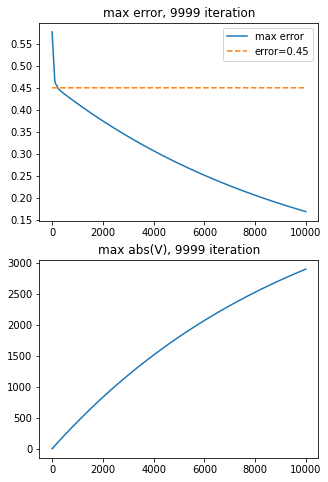

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open("/content/drive/My Drive/2020_FALL/Research/RL/LiteratReview/data/New Text Document (3).txt","rb") as fp:
  haha = fp.readlines()
#print(haha)
data_tol = str(haha)
data_tol = data_tol[3:-6].split("\\r\\n', b'")
data_tol = [list(map(float,data_tol[i].split(' '))) for i in range(len(data_tol))]

N = len(data_tol)
data_tol = np.array(data_tol)[0:N].T

f,(ax1, ax2) = plt.subplots(2, 1,figsize=(5,8))
ax1.plot(data_tol[0]-1,data_tol[1],data_tol[0]-1,0.45*np.ones(data_tol[0].shape),'--')
ax1.legend(['max error','error=0.45'])
ax1.set_title("max error, {} iteration".format(N))
#plt.show()
ax2.plot(data_tol[0]-1,data_tol[2])
ax2.set_title("max abs(V), {} iteration".format(N))

plt.show()

In [3]:
from sklearn import preprocessing

import pandas as pd

import numpy as np

import scipy.optimize as opt

import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib import cm

from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D 

from scipy.optimize import  shgo

from scipy.optimize import differential_evolution

#dat = pd.read_csv('group4.csv')
path = '/content/drive/My Drive/2020_FALL/Research/RL/LiteratReview/'

dat3 = pd.read_csv(path+'group4_new_175.csv') # a dataframe has two columns, named "state" and "action".

#%%

class FullLikelihood(object):

    def __init__(self, data, Y, X, npars ,dim_x,dim_z,time, nbus,hide_state = True):

        """

        A statistics workbench used to evaluate the cost parameters underlying 

        a bus replacement pattern by a forward-looking agent.

        

        Takes:

            * Data: a Pandas dataframe, which contains:

                -Y: the name of the column containing the dummy exogenous 

                    variable (here, the choice)

                -X: the name of the column containing the endogenous variable 

                    (here, the state of the bus)



            * p: The state-transition vector of endogenous variable.

                    For instance, p = [0, 0.6, 0.4] means that the bus will 

                    transition to the next mileage state with probability 0.6, 

                    and to the second next mileage state with probability 0.4.



            * MF: A function passed as an argument, which is the functional 

                  form for the maintenance cost. This function must accept as

                  a first argument a state s, and as a second argument a vector

                  of parameters.

                  

            * npars: The number of parameters to evalutate (i.e. the number of 

                     parameters of the maintenance cost function, plus 1 for

                     the replacement cost)

            

            * time: The length of time horizon of the observations.

            

            * nbus: The number of buses.

        """        

        self.hide_state = hide_state

        self.endog = data.loc[:, Y].values

        self.exog = data.loc[:, X].values

        self.time = time

        self.nbus = nbus

        self.data = np.array(data)

        self.dim = dim_x 

        self.N = self.endog.shape[0]

        self.S = dim_z # Assumes that the true maximum number 

                                         # states is twice the maximum observed

                                         # state.

        self.D = [(i,j/(self.dim-1)) for i in range(self.S) for j in range(self.dim)]

        self.Dlength = self.S*self.dim

        #self.theta2 = theta2

        # Check that the stated number of parameters correspond to the

        # specifications of the maintenance cost function. 

        

              

        # To speed up computations and avoid loops when computing the log 

        # likelihood, we create a few useful matrices here:

        length = self.Dlength

        

        

        # A (SxS) matrix indicating the probability of a bus transitioning

        # from a state s to a state s' (used to compute maintenance utility)

                # A second (SxS) matrix which regenerates the bus' state to 0 with

        # certainty (used to compute the replacement utility)
        #print(np.zeros((self.dim-1, length)).shape)

        self.regen_mat = np.vstack((np.zeros((self.dim-1, length)),np.ones((1,length)),np.zeros((length-self.dim, length))))

        

        # A (2xN) matrix indicating with a dummy the decision taken by the agent

        # for each time/bus observation (replace or maintain)

        self.dec_mat = np.vstack(((1-self.endog), self.endog))

        

    def trans(self, theta2,p0,p1):

        """

        This function generate the transition matrix

            

            * theta2: the true state transition probability

            

            * p0: the transition probability when s = 0

            

            * p1: the transition probability when s = 1

        """

        S = self.S

        D = self.D

        dim = self.dim

        length = self.Dlength

        p_0 = np.array([p0[0],p1[0]])

        p_0 = np.around(p_0,3)

        p_1 = np.array([p0[1],p1[1]])

        p_1 = np.around(p_1,3)

        p_2 = np.array([p0[2],p1[2]])

        p_2 = np.around(p_2,3)

        p_3 = 1-p_0-p_1-p_2

        #p_2 = np.array(([0,0],p_2)).max(0)

        self.P = P = np.array((p_0,p_1,p_2,p_3))

        #print(self.P)

        trans_mat = np.zeros((length, length))

        new_x0 = lambda x: np.dot(p_0*np.array([x,1-x]),theta2)/np.dot(p_0,[x,1-x])

        new_x1 = lambda x: np.dot(p_1*np.array([x,1-x]),theta2)/np.dot(p_1,[x,1-x])

        new_x2 = lambda x: np.dot(p_2*np.array([x,1-x]),theta2)/np.dot(p_2,[x,1-x])

        new_x3 = lambda x: np.dot(p_3*np.array([x,1-x]),theta2)/np.dot(p_3,[x,1-x])

        matrix0 = [new_x0(i/(dim-1)) for i in range(dim)]

        matrix1 = [new_x1(i/(dim-1)) for i in range(dim)]

        matrix2 = [new_x2(i/(dim-1)) for i in range(dim)]

        matrix3 = [new_x3(i/(dim-1)) for i in range(dim)]

        self.matrix = x_matrix = np.vstack((matrix0,matrix1,matrix2,matrix3))

        for i in range(length):

            z_cur = D[i][0]

            x_cur = D[i][1]

            for j in range(4):

                if self.hide_state == True:

                    x_new = x_matrix[j][int(x_cur*(dim-1))]

                    

                else:

                    x_new = 1

                x_f = np.floor((self.dim-1)*x_new)/(self.dim-1)

                    #x_c = np.ceil((self.dim-1)*x_new)/(self.dim-1)

                coe = (x_new-x_f)*(self.dim - 1)

                if z_cur + j < S-1:

                    ind = D.index((z_cur + j,x_f))

                    trans_mat[ind][i] = (1-coe)*np.dot(P[j],[x_cur,1-x_cur])

                    if x_f != 1:

                        trans_mat[ind+1][i] = coe*np.dot(P[j],[x_cur,1-x_cur])

                elif z_cur + j >= S-1:

                    ind = D.index((S-1,x_f))

                    trans_mat[ind][i] += (1-coe)*np.dot(P[j],[x_cur,1-x_cur])

                    if x_f != 1:

                        trans_mat[ind+1][i] += coe*np.dot(P[j],[x_cur,1-x_cur])

                else:

                    pass

        return trans_mat

        

    def single_trans(self, p,gap):

        S = self.S

        trans_mat = np.zeros((S, S))

        for i in range(S):

            if i + gap < S-1:

                trans_mat[i+gap][i] = p

            elif i + gap == S-1:

                trans_mat[S-1][i] = p

            else:

                pass

        return trans_mat

        """

        self.trans_mat[S-1][S-1] = 0

        self.trans_mat[S-1][0] = 1

        """

    def belief(self,theta2,p0,p1, path):

        """

        This function return the belief x

        Takes:

            * theta2: the true state transition probability

            

            * p0: the transition probability when s = 0

            

            * p1: the transition probability when s = 1

            

            * A path of mileage and replacement\maintenance record data

        """

        length = self.time

        x = [1]

        p_0 = np.array([p0[0],p1[0]])

        p_1 = np.array([p0[1],p1[1]])

        p_2 = np.array([p0[2],p1[2]])

        p_3 = 1-p_0-p_1-p_2
        #print(length,path)

        for i in range(length-1):

            if path[i][1] == 1:

                x_new = 1

                x.append(x_new)

            else:

                #x_f = np.floor((self.dim-1)*x[-1])/(self.dim-1)

                #x_c = np.ceil((self.dim-1)*x[-1])/(self.dim-1)

                #coe = (x[-1]-x_f)*(self.dim - 1)

                #x_cur = np.array([x_c*coe+x_f*(1-coe), coe*(1-x_c)+ (1-coe)*(1-x_f)])

                x_cur= np.array([x[-1],1-x[-1]])

                gap = path[i+1][0]-path[i][0]

                if gap == 0:

                    v1 = np.dot(p_0,x_cur)

                    v2 = np.dot(p_0,np.diag(x_cur))

                    v3 = np.dot(v2,theta2)

                    x_new = v3/v1

                    x.append(x_new)

                elif gap == 1:

                    v1 = np.dot(p_1,x_cur)

                    v2 = np.dot(p_1,np.diag(x_cur))

                    v3 = np.dot(v2,theta2)

                    x_new = v3/v1

                    x.append(x_new)

                elif gap == 2:

                    v1 = np.dot(p_2,x_cur)

                    v2 = np.dot(p_2,np.diag(x_cur))

                    v3 = np.dot(v2,theta2)

                    x_new = v3/v1

                    x.append(x_new)

                else:

                    v1 = np.dot(p_3,x_cur)

                    v2 = np.dot(p_3,np.diag(x_cur))

                    v3 = np.dot(v2,theta2)

                    x_new = v3/v1

                    x.append(x_new)

        return x

    """

    def v_value(self,params,theta2,p0,p1 ,beta=0.9999):

        S = self.S

        dim = self.dim

        p_0 = np.array([p0[0],p1[0]])

        p_1 = np.array([p0[1],p1[1]])

        p_2 = 1-p_0-p_1

        rc = params[0]

        thetas = np.array(params[1:])

        maintain = lambda x,s: np.dot(0.001*s*thetas,[x,1-x])

        self.q_0 = [maintain(j/(dim-1),0) for j in range(0,dim)]

        for i in range(S-1):

            q = [maintain(j/(dim-1),i+1) for j in range(0,dim)]

            self.q_0 = np.vstack((self.q_0,q))

        reward_0 = self.q_0

        reward_1 = self.q_1 = np.zeros((S,dim))+rc

        m = np.array((self.q_0,self.q_1)).min(0)

        EV = np.log(np.exp(-self.q_0+m)+np.exp(-self.q_1+m))-m+0.5772

        for i in range(1000):

            new_x0 = lambda x: np.floor((self.dim-1)*p_0[0]*x*theta2/np.dot(p_0,[x,1-x]))/(self.dim-1)

            new_x1 = lambda x: np.floor((self.dim-1)*p_1[0]*x*theta2/np.dot(p_1,[x,1-x]))/(self.dim-1)

            new_x2 = lambda x: np.floor((self.dim-1)*p_2[0]*x*theta2/np.dot(p_2,[x,1-x]))/(self.dim-1)

            self.q_0 = reward_0 + beta*[]

            

    """

    def myopic_costs(self, params):

        length = self.Dlength

        D = self.D

        """

        This function computes the myopic expected cost associated with each 

        decision for each state.

        

        Takes:

            * A vector params, to be supplied to the maintenance cost function 

              MF. The first element of the vector is the replacement cost rc.

              



        Returns:

            * A (Sx2) array containing the maintenance and replacement costs 

              for the S possible states of the bus

        """

        rc = params[0]

        thetas = np.array(params[1:])

        maint_cost = np.array([np.dot(0.001*D[d][0]*thetas,[D[d][1],1-D[d][1]]) for d in range(0, length)])

        repl_cost = [rc for d in range(0, length)]

        #maint_cost[S-1] = 1e+10

        return  np.vstack((maint_cost, repl_cost)).T

    

    def fl_costs(self, params,theta2,p0,p1 ,beta=0.9999):

        """

        Compute the non-myopic expected value of the agent for each possible 

        decision and each possible state of the bus, conditional on a vector of 

        parameters and on the maintenance cost function specified at the 

        initialization of the DynamicUtility model.



        Iterates until the difference in the previously obtained expected value 

        and the new expected value is smaller than a constant.

        

        Takes:

            * A vector params for the cost function

            * theta2: hiden state transition probability

            * p0: the transition probability when s = 0

            * p1: the transition probability when s = 1

            * A discount factor beta (optional)

            * A convergence threshold (optional)

            * A boolean argument to suppress the output (optional)



        Returns:

            * An (Sx2) array of forward-looking costs associated with each

              state and each decision.

        """

        # Initialization of the contraction mapping

        self.EV_myopic = EV_new =self.myopic_costs(params)

        self.trans_mat = self.trans(theta2,p0,p1)

        # Contraction mapping Loop

        for i in range(1000):

            length = self.Dlength

            #D = self.D

            #pchoice = self.choice_prob(EV)

            #ecost = (pchoice*EV).sum(1)-0.5772

            EV = EV_new

            m = EV.min(1).reshape(length, -1)

            ecost = np.log(np.exp(-EV+m).sum(1) )-m.T+0.5772

            

            #ecost = lambda x: np.log(np.exp(-EV(x)).sum(1)) + 0.5772

            futil_maint = np.dot(ecost, self.trans_mat)

            futil_repl = np.dot(ecost, self.regen_mat)

            futil = np.vstack((futil_maint, futil_repl)).T

            EV_new = self.EV_myopic - beta*futil



        # Output:

        """

        if not suppr_output:

            if achieved:

                print("Convergence achieved in {} iterations".format(k))

            else:

                print("CM could not converge! Mean difference = {:.4f}".format(

                                                            (EV_new-EV).mean())

                                                                              )

    """

                

        self.EV_FL = EV_new

        return EV_new



    def choice_prob(self,rho ,cost_array):

        """

        Returns the probability of each choice for each observed state, 

        conditional on an array of state/decision costs (generated by the 

        myopic or forward-looking cost functions)

        """

        cost_array = cost_array/rho

        cost = cost_array - cost_array.min(1).reshape(self.Dlength, -1)

        util = np.exp(-cost)

        pchoice = util/(np.sum(util, 1).reshape(self.Dlength, -1))

        return pchoice

        

    def loglike2(self,parameters):

        theta2 = self.theta2

        p0 = parameters[0:3]

        p1 = parameters[3:6]

        prob0 = np.array([p0[0],p1[0]])

        #prob0 = np.around(prob0,3)

        prob1 = np.array([p0[1],p1[1]])

        #prob1 = np.around(prob1,3)

        prob2 = np.array([p0[2],p1[2]])

        prob3 = 1 - prob0 -prob1 - prob2

        mileage = self.exog

        if self.hide_state == True:

            self.beli = []

            for i in range(self.nbus):
                #print(i,len(self.beli))

                self.beli = self.beli + self.belief(theta2,p0,p1,self.data[i*self.time:(i+1)*self.time])

        else:

            self.beli = [1 for s in range(0,self.N)]
        #print('end')

        logprob = 0

        for i in range(self.N-1):

            x_cur = [self.beli[i], 1-self.beli[i]]

            if mileage[i+1] - mileage[i] == 0:

                logprob += np.log(np.dot(prob0,x_cur))

            elif mileage[i+1] - mileage[i] == 1:

                logprob += np.log(np.dot(prob1,x_cur))

            elif mileage[i+1] - mileage[i] == 2:

                logprob += np.log(np.dot(prob2,x_cur))

            elif mileage[i+1] - mileage[i] == 3:

                logprob += np.log(np.dot(prob3,x_cur))
        #print('end')

        return -logprob

    def loglike(self, parameters):

        """

        The log-likelihood of the Dynamic model is estimated in several steps.

        1°) The current parameters are supplied to the contraction mapping 

            function

        2°) The function returns a matrix of decision probabilities for each 

            state.

        3°) This matrix is used to compute the loglikelihood of the 

            observations

        4°) The log-likelihood are then summed accross individuals, and 

            returned

        """

        params = parameters[0:3]

        rho = 1

        #theta2 = self.fitted_full.x

        p0 = self.fitted2.x[0:3]

        p1 = self.fitted2.x[3:6]

        theta2 = self.theta2

        #p0 = self.p0

        #p1 = self.p1

        #prob2 = np.array(([0,0],prob2)).max(0)

        util = self.fl_costs(params,theta2,p0,p1) 

        self.pchoice = pchoice =self.choice_prob(rho,util)

        mileage = self.exog

        self.beli = []
        #print(self.data.shape())

        for i in range(self.nbus):
            #print(i)
            #print(self.data[i*self.time:(i+1)*self.time])
            #print(self.belief(theta2,p0,p1,self.data[i*self.time:(i+1)*self.time]))

            self.beli = self.beli + self.belief(theta2,p0,p1,self.data[i*self.time:(i+1)*self.time])

        # A (SxN) matrix indicating the state of each observation

        b_f = np.floor((self.dim-1)*np.array(self.beli))/(self.dim-1)

        self.b_coe = (self.beli-b_f)*(self.dim-1)

        self.state_mat_f = np.array([[(1-self.b_coe[i])*(mileage[i]==j and np.floor(self.beli[i]) == m) for i in range(self.N)] 

                                                    for (j,m) in self.D])

        self.state_mat_c = np.array([[self.b_coe[i]*(mileage[i]==j and np.ceil(self.beli[i]) == m) for i in range(self.N)] 

                                                    for (j,m) in self.D])

        self.state_mat = self.state_mat_f+self.state_mat_c 

        logprob = np.log(np.dot(pchoice.T, self.state_mat))

        logprob = np.sum(self.dec_mat*logprob)
        
        ############################My Code############################
        print(parameters,logprob)
        ###############################End#############################

        #logprob = np.log(np.dot(pchoice.T, self.state_mat))

        #return -np.sum(self.dec_mat*logprob)-(count_0 * np.log(p1) + count_1 * np.log(p2) + count_2 * np.log(p3))

        return -logprob

    

    def loglike_full(self,theta2):

        self.theta2 = theta2

        self.fit_likelihood2()

        loglike = -self.fitted2.fun 
        ############################My Code############################
        print(theta2,loglike)
        ###############################End#############################

        return -loglike

    def fit_likelihood(self, x0=None, bounds=None):

        """

        estimate the reward parameter

        """

        if bounds == None:

            bounds = [(1e-6, 100),(1e-6,100),(1e-6,100)]

            

        if x0 == None:

            x0 =  [10,1.1,1.1]

        cons= ({'type': 'ineq', 'fun': lambda x: x[2]-x[1] })

        #cons= ({'type': 'ineq', 'fun': lambda x: 1-x[4]-x[5]-1e-6 },{'type': 'ineq', 'fun': lambda x: 1-x[6]-x[7]-1e-6 })

        self.fitted = minimize(self.loglike, x0=x0,bounds = bounds, constraints= cons)

        #self.fitted = opt.fmin_l_bfgs_b(self.loglike, x0=x0, approx_grad=True, 

                                       # bounds=bounds)

        #self.fitted = differential_evolution(self.loglike, bounds)

    def fit_likelihood2(self):

        """

        estimate the dynamic

        """

        bounds = [(0.001, 0.998),(0.001, 0.998),(0.001, 0.998),(0.001, 0.998),(0.001, 0.998),(0.001, 0.998)]

        x0 = [0.1,0.1,0.1,0.1,0.1,0.1]

        cons= ({'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]-x[2]-0.001 },{'type': 'ineq', 'fun': lambda x: 1-x[3]-x[4]-x[5]-0.001 },\

                {'type': 'ineq', 'fun': lambda x: -3*x[0]-2*x[1]-x[2]+3*x[3]+2*x[4]+x[5] })

        self.fitted2 = minimize(self.loglike2, x0=x0,bounds = bounds, constraints= cons)

    def fit(self):

        """

        estimate the belif parameter

        """

#        bounds = [(0,0.99999),(0,0.99999)]
#
#        #x0 = [0.1,0.1]
#
#        #self.fitted_full = minimize(self.loglike_full, x0=x0,bounds = bounds)
#
#        #self.fitted_full  = differential_evolution(self.loglike_full, bounds)
#
#        #self.fitted_full = shgo(self.loglike_full, bounds)
#
#        self.fitted_full = opt.brute(self.loglike_full, bounds)
        
        #########################My Code############################
        # inorder to accelerate the computing speed
        bounds = [(0.9,0.99999),(0,0.09999)]

        self.fitted_full = opt.brute(self.loglike_full, bounds,Ns=3)
        ##########################End################################
        #self.theta2 = self.fitted_full.x

        self.theta2 = self.fitted_full

    

     #%%

"""

def lin_cost(s, params, x):

    try:

        theta1 = params

        return np.dot(s*theta1, [x,1-x])

    except ValueError:

        raise ValueError

        print("Wrong number of parameters specified: expected 2, got {}".format(len(params))

"""



#estimation = FullLikelihood(dat3,'action','state', npars=2,dim_x =51,dim_z = 175,time = 117, nbus = 37,hide_state = True)       


############################My Code###########################################
import random
import pickle
import os
##seed = 1
##Kfold = 5
## i = 0,1,2,3,4
##code for save data
#with open("./data/seed{}_{}Kfold_{}.txt".format(seed,Kfold,i+1), "wb") as fp:   #Pickling
#    pickle.dump(rust_hid, fp)
#       
##code for load data
#with open("./data/seed{}_{}Kfold_{}.txt".format(seed,Kfold,i+1), "rb") as fp:   #Pickling
#    rust_hid = pickle.load(fp))     


time = 117
nbus = 37

def boostrap(seed,data=dat3,time=time,nbus=nbus):
    """
    Input:
        seed:   random seed, record of randomized ranking,
                in order to consistent with rust 1987 model
        nbus:   number of sample size, 37, in 'group4_new_175.cvs'
        time:   length of each sample path, 117, in 'group4_new_175.cvs'
        data:   data from 'gourp4_new_175.cvs'

    
    Output:
        dat_new:  keep record of new samples
    """
    np.random.seed(seed)
    samples = np.random.randint(0,nbus,nbus)
    state_new = np.zeros(time*nbus)
    action_new = np.zeros(time*nbus)
    for i,ss in enumerate(samples):
        j = time*i
        state_new[j:j+time] = data['state'][ss*time:(ss+1)*time]
        action_new[j:j+time] = data['action'][ss*time:(ss+1)*time]
    data = {'state':state_new,'action':action_new}
    dat_new = pd.DataFrame(data=data)
    #print(samples)
    #print(dat_new)
    return dat_new

seed_tol = np.arange(0,1000,dtype=int)  #0,1,2,3,4,5,6,7,8,9

data_tol = []
for seed in seed_tol:
    data_new = boostrap(seed,data=dat3,time=time,nbus=nbus)

    print('\n\n{} seed,\n'.format(seed))

    #Record in form: theta2, logSigma, theta3, ccp, [Rc,r1,r2]
    data_record = [] 
    #data_record.append(seed)
    
    estimation = FullLikelihood(data_new,'action','state', 
                               npars=2,dim_x =51,dim_z = 175,time = time,
                               nbus = nbus,hide_state = True)
   
    #theta2
    estimation.fit()
    print(estimation.fitted_full)
   
    data_record.append(estimation.fitted_full)

    #theta3 and logSigma
    estimation.fit_likelihood2()
    print(estimation.fitted2) 
   
    data_record.append(estimation.fitted2.fun)
    data_record.append(estimation.fitted2.x)
   
    #[Rc,r1,r2] and ccp
    estimation.fit_likelihood()
    print(estimation.fitted)
   
    data_record.append(estimation.fitted.fun)
    data_record.append(estimation.fitted.x)
   
    #Save record
    if not os.path.exists(path+'data'):
        os.makedirs(path+'data')
    with open(path+'/data/seed{}_hidden.txt'.format(seed), "wb") as fp:   #Pickling
        pickle.dump(data_record, fp)

# data_record = [] 
    
# estimation = FullLikelihood(dat3,'action','state', 
#                                 npars=2,dim_x =51,dim_z = 175,time = time,
#                                 nbus = nbus,hide_state = True)
    
# #theta2
# estimation.fit()
# print(estimation.fitted_full)
    
# data_record.append(estimation.fitted_full)

# #theta3 and logSigma
# estimation.fit_likelihood2()
# print(estimation.fitted2) 
    
# data_record.append(estimation.fitted2.fun)
# data_record.append(estimation.fitted2.x)
    
# #[Rc,r1,r2] and ccp
# estimation.fit_likelihood()
# print(estimation.fitted)

# data_record.append(estimation.fitted.fun)
# data_record.append(estimation.fitted.x)
    
#Save record
with open(path+'/data/seed{}_{}.txt'.format(seed_tol[0],seed_tol[-1]), "wb") as fp:   #Pickling
        pickle.dump(data_record, fp)
#############################End#############################################

"""

x0 = [10.2910,2.2,2.5,0.99,0,0.257,0.717,0.526,0.473]

a = estimation.loglike_full(x0)

#b = estimation.beli [10,0.01,0.02,0,0.4,0.55,0.4,0.55]

estimation.print_parameters()

#myopic = estimation.myopic_costs([10,1,1])

"""






0 seed,



KeyboardInterrupt: ignored